In [4]:
import pickle
import networkx as nx

In [31]:
with open("/Users/benjaminhinshaw/Documents/GitHub/Analysis-of-Corporate-Hypergraph-Motifs/PickleGraphs/multigraph2022.p", 'rb') as f:  # notice the r instead of w
    G_loaded = pickle.load(f)

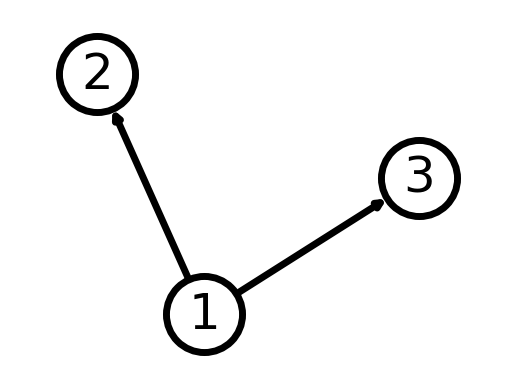

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.MultiDiGraph()
G.add_edge(1, 2)
G.add_edge(1, 3)


# explicitly set positions
pos = {1: (0, 0), 2: (-1, 0.3), 3: (2, 0.17), 4: (4, 0.255), 5: (5, 0.03)}

options = {
    "font_size": 36,
    "node_size": 3000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}
nx.draw_networkx(G, pos, **options)

# Set margins for the axes so that nodes aren't clipped
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

In [55]:
# See https://github.com/networkx/networkx/pull/1474
# Copyright 2011 Reya Group <http://www.reyagroup.com>
# Copyright 2011 Alex Levenson <alex@isnotinvain.com>
# Copyright 2011 Diederik van Liere <diederik.vanliere@rotman.utoronto.ca>
"""Functions for analyzing triads of a graph."""

from collections import defaultdict
from itertools import combinations, permutations

import networkx as nx
from networkx.utils import not_implemented_for, py_random_state

__all__ = [
    "triadic_census",
    "is_triad",
    "all_triplets",
    "all_triads",
    "triads_by_type",
    "triad_type",
    "random_triad",
]

#: The integer codes representing each type of triad.
#:
#: Triads that are the same up to symmetry have the same code.
TRICODES = (
    1,
    2,
    2,
    3,
    2,
    4,
    6,
    8,
    2,
    6,
    5,
    7,
    3,
    8,
    7,
    11,
    2,
    6,
    4,
    8,
    5,
    9,
    9,
    13,
    6,
    10,
    9,
    14,
    7,
    14,
    12,
    15,
    2,
    5,
    6,
    7,
    6,
    9,
    10,
    14,
    4,
    9,
    9,
    12,
    8,
    13,
    14,
    15,
    3,
    7,
    8,
    11,
    7,
    12,
    14,
    15,
    8,
    14,
    13,
    15,
    11,
    15,
    15,
    16,
)

#: The names of each type of triad. The order of the elements is
#: important: it corresponds to the tricodes given in :data:`TRICODES`.
TRIAD_NAMES = (
    "003",
    "012",
    "102",
    "021D",
    "021U",
    "021C",
    "111D",
    "111U",
    "030T",
    "030C",
    "201",
    "120D",
    "120U",
    "120C",
    "210",
    "300",
)


#: A dictionary mapping triad code to triad name.
TRICODE_TO_NAME = {i: TRIAD_NAMES[code - 1] for i, code in enumerate(TRICODES)}


def _tricode(G, v, u, w):
    """Returns the integer code of the given triad.

    This is some fancy magic that comes from Batagelj and Mrvar's paper. It
    treats each edge joining a pair of `v`, `u`, and `w` as a bit in
    the binary representation of an integer.

    """
    combos = ((v, u, 1), (u, v, 2), (v, w, 4), (w, v, 8), (u, w, 16), (w, u, 32))
    return sum(x for u, v, x in combos if v in G[u])


def triadic_census(G, nodelist=None):
    TRIAD_NAMES = (
        "003",
        "012",
        "102",
        "021D",
        "021U",
        "021C",
        "111D",
        "111U",
        "030T",
        "030C",
        "201",
        "120D",
        "120U",
        "120C",
        "210",
        "300",
    )
    all_triads = {}

    for i in TRIAD_NAMES:
        all_triads[i] = 0

    triad_belongings = {}
    for i in G.nodes():
        triad_belongings[i] = all_triads.copy()
    
    
    """Determines the triadic census of a directed graph.

    The triadic census is a count of how many of the 16 possible types of
    triads are present in a directed graph. If a list of nodes is passed, then
    only those triads are taken into account which have elements of nodelist in them.

    Parameters
    ----------
    G : digraph
       A NetworkX DiGraph
    nodelist : list
        List of nodes for which you want to calculate triadic census

    Returns
    -------
    census : dict
       Dictionary with triad type as keys and number of occurrences as values.

    Examples
    --------
    >>> G = nx.DiGraph([(1, 2), (2, 3), (3, 1), (3, 4), (4, 1), (4, 2)])
    >>> triadic_census = nx.triadic_census(G)
    >>> for key, value in triadic_census.items():
    ...     print(f"{key}: {value}")
    003: 0
    012: 0
    102: 0
    021D: 0
    021U: 0
    021C: 0
    111D: 0
    111U: 0
    030T: 2
    030C: 2
    201: 0
    120D: 0
    120U: 0
    120C: 0
    210: 0
    300: 0

    Notes
    -----
    This algorithm has complexity $O(m)$ where $m$ is the number of edges in
    the graph.

    For undirected graphs, the triadic census can be computed by first converting
    the graph into a directed graph using the ``G.to_directed()`` method.
    After this conversion, only the triad types 003, 102, 201 and 300 will be
    present in the undirected scenario.

    Raises
    ------
    ValueError
        If `nodelist` contains duplicate nodes or nodes not in `G`.
        If you want to ignore this you can preprocess with `set(nodelist) & G.nodes`

    See also
    --------
    triad_graph

    References
    ----------
    .. [1] Vladimir Batagelj and Andrej Mrvar, A subquadratic triad census
        algorithm for large sparse networks with small maximum degree,
        University of Ljubljana,
        http://vlado.fmf.uni-lj.si/pub/networks/doc/triads/triads.pdf

    """
    nodeset = set(G.nbunch_iter(nodelist))
    if nodelist is not None and len(nodelist) != len(nodeset):
        raise ValueError("nodelist includes duplicate nodes or nodes not in G")

    N = len(G)
    Nnot = N - len(nodeset)  # can signal special counting for subset of nodes

    # create an ordering of nodes with nodeset nodes first
    m = {n: i for i, n in enumerate(nodeset)}

    
    if Nnot:
        # add non-nodeset nodes later in the ordering
        not_nodeset = G.nodes - nodeset
        m.update((n, i + N) for i, n in enumerate(not_nodeset))

    # build all_neighbor dicts for easy counting
    # After Python 3.8 can leave off these keys(). Speedup also using G._pred
    # nbrs = {n: G._pred[n].keys() | G._succ[n].keys() for n in G}
    nbrs = {n: G.pred[n].keys() | G.succ[n].keys() for n in G}
    dbl_nbrs = {n: G.pred[n].keys() & G.succ[n].keys() for n in G}

    if Nnot:
        sgl_nbrs = {n: G.pred[n].keys() ^ G.succ[n].keys() for n in not_nodeset}
        # find number of edges not incident to nodes in nodeset
        sgl = sum(1 for n in not_nodeset for nbr in sgl_nbrs[n] if nbr not in nodeset)
        sgl_edges_outside = sgl // 2
        dbl = sum(1 for n in not_nodeset for nbr in dbl_nbrs[n] if nbr not in nodeset)
        dbl_edges_outside = dbl // 2

    # Initialize the count for each triad to be zero.
    census = {name: 0 for name in TRIAD_NAMES}
    # Main loop over nodes
    for v in nodeset:
        vnbrs = nbrs[v]
        dbl_vnbrs = dbl_nbrs[v]
        if Nnot:
            # set up counts of edges attached to v.
            sgl_unbrs_bdy = sgl_unbrs_out = dbl_unbrs_bdy = dbl_unbrs_out = 0
        for u in vnbrs:
            if m[u] <= m[v]:
                continue
            unbrs = nbrs[u]
            neighbors = (vnbrs | unbrs) - {u, v}
            # Count connected triads.
            for w in neighbors:
                if m[u] < m[w] or (m[v] < m[w] < m[u] and v not in nbrs[w]):
                    code = _tricode(G, v, u, w)
                    census[TRICODE_TO_NAME[code]] += 1

                    ### INSERT MY CODE HERE
                    triad_belongings[u][TRICODE_TO_NAME[code]] += 1
                    triad_belongings[v][TRICODE_TO_NAME[code]] +=1
                    triad_belongings[w][TRICODE_TO_NAME[code]] +=1
                    


            # Use a formula for dyadic triads with edge incident to v
            if u in dbl_vnbrs:
                census["102"] += N - len(neighbors) - 2
            else:
                census["012"] += N - len(neighbors) - 2

            # Count edges attached to v. Subtract later to get triads with v isolated
            # _out are (u,unbr) for unbrs outside boundary of nodeset
            # _bdy are (u,unbr) for unbrs on boundary of nodeset (get double counted)
            if Nnot and u not in nodeset:
                sgl_unbrs = sgl_nbrs[u]
                sgl_unbrs_bdy += len(sgl_unbrs & vnbrs - nodeset)
                sgl_unbrs_out += len(sgl_unbrs - vnbrs - nodeset)
                dbl_unbrs = dbl_nbrs[u]
                dbl_unbrs_bdy += len(dbl_unbrs & vnbrs - nodeset)
                dbl_unbrs_out += len(dbl_unbrs - vnbrs - nodeset)
        # if nodeset == G.nodes, skip this b/c we will find the edge later.
        if Nnot:
            # Count edges outside nodeset not connected with v (v isolated triads)
            census["012"] += sgl_edges_outside - (sgl_unbrs_out + sgl_unbrs_bdy // 2)
            census["102"] += dbl_edges_outside - (dbl_unbrs_out + dbl_unbrs_bdy // 2)

    # calculate null triads: "003"
    # null triads = total number of possible triads - all found triads
    total_triangles = (N * (N - 1) * (N - 2)) // 6
    triangles_without_nodeset = (Nnot * (Nnot - 1) * (Nnot - 2)) // 6
    total_census = total_triangles - triangles_without_nodeset
    census["003"] = total_census - sum(census.values())

    return census, triad_belongings




In [54]:
TRIAD_NAMES = (
    "003",
    "012",
    "102",
    "021D",
    "021U",
    "021C",
    "111D",
    "111U",
    "030T",
    "030C",
    "201",
    "120D",
    "120U",
    "120C",
    "210",
    "300",
)
print(G)
print(G.nodes)
dict1 = {}
all_triads = {}

for i in TRIAD_NAMES:
    all_triads[i] = 0

for i in G.nodes():
    dict1[i] = all_triads.copy()

print(dict1[1])

MultiDiGraph with 3 nodes and 2 edges
[1, 2, 3]
{'003': 0, '012': 0, '102': 0, '021D': 0, '021U': 0, '021C': 0, '111D': 0, '111U': 0, '030T': 0, '030C': 0, '201': 0, '120D': 0, '120U': 0, '120C': 0, '210': 0, '300': 0}


In [47]:
print(G_loaded.nodes())

interlock = nx.get_edge_attributes(G_loaded, "n_interlock", default=0)
print(interlock)
subsidiary = nx.get_edge_attributes(G_loaded, "subsidiary", default=0)
print(subsidiary)





[712534.0, 1562463.0, 34782.0, 866706.0, 1104657.0, 65270.0, 1750.0, 1433660.0, 860748.0, 94049.0, 1808834.0, 1144215.0, 927003.0, 1001902.0, 897077.0, 923120.0, 766421.0, 831641.0, 1097149.0, 1639691.0, 896262.0, 835324.0, 5981.0, 1065837.0, 794619.0, 715787.0, 1047127.0, 836690.0, 6176.0, 63296.0, 720500.0, 84748.0, 109563.0, 795403.0, 7789.0, 9092.0, 792987.0, 896493.0, 104918.0, 1162461.0, 1113232.0, 730255.0, 1039399.0, 760498.0, 24090.0, 946673.0, 1177394.0, 902791.0, 814585.0, 729580.0, 1377630.0, 1048477.0, 879169.0, 949870.0, 827187.0, 719135.0, 23197.0, 906553.0, 1212545.0, 933974.0, 16040.0, 811596.0, 913142.0, 1320414.0, 16058.0, 1049521.0, 813672.0, 851520.0, 727273.0, 1333493.0, 1342423.0, 866829.0, 318833.0, 16160.0, 36146.0, 1144879.0, 1378950.0, 1114925.0, 740664.0, 1035201.0, 837465.0, 797721.0, 911177.0, 822818.0, 708781.0, 1423221.0, 1067294.0, 1124941.0, 3197.0, 749647.0, 1137883.0, 1104506.0, 1071739.0, 1220754.0, 914475.0, 94344.0, 887733.0, 275053.0, 944148.0, 1

In [59]:
census, belongings = triadic_census(G_loaded)
print(census)


{'003': 109931772, '012': 404952, '102': 168546, '021D': 3350, '021U': 11, '021C': 47, '111D': 42, '111U': 171, '030T': 0, '030C': 0, '201': 98, '120D': 0, '120U': 1, '120C': 0, '210': 0, '300': 6}


In [61]:
list1 = []
for i in belongings.keys():
    if belongings[i]['120U'] >=1:
        list1.append(i)
print(list1)

[84748.0, 1257640.0, 72162.0]
